In [35]:
!pip install -q transformers

In [37]:
model_checkpoint="facebook/wav2vec2-base-960h"

In [38]:
# For managing audio file
import librosa

#Importing Pytorch
import torch

#Importing Wav2Vec
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [39]:
import IPython.display as display
display.Audio("/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Bayer_4.wav", autoplay=True)

In [40]:
# Loading the audio file
audio, rate = librosa.load("/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Bayer_4.wav", sr = 16000)

In [41]:
print(audio)
print(rate)

[ 1.3097657e-09 -5.3536913e-09  8.6590433e-09 ...  7.6849537e-05
  2.8861716e-04  0.0000000e+00]
16000


In [42]:
# Importing Wav2Vec pretrained model

tokenizer = Wav2Vec2Tokenizer.from_pretrained(model_checkpoint)
model = Wav2Vec2ForCTC.from_pretrained(model_checkpoint)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.9/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:757: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Taking an input value

input_values = tokenizer(audio, return_tensors = "pt").input_values

In [44]:
# Storing logits (non-normalized prediction values)
logits = model(input_values).logits

In [45]:
# Storing predicted ids
prediction = torch.argmax(logits, dim = -1)

In [46]:
# Passing the prediction to the tokenzer decode to get the transcription
transcription = tokenizer.batch_decode(prediction)[0]

In [47]:
print(transcription)

VEISH


## load to dataset

In [48]:
!pip install -q datasets[audio]

In [49]:
num_classes = 10
class_names = ['Tylenol', 'Advil', 'Bayer', 'Aleve', 'Panadol', 'Voltaren', 'Ponstel', 'Dolo', 'Indocin', 'Pyridium']
max_duration = 20.0

In [50]:
from datasets import load_dataset
from datasets import load_metric

In [51]:
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/Dataset/fyp_dataset_final", split="train")

Resolving data files:   0%|          | 0/901 [00:00<?, ?it/s]

In [52]:
from datasets import ClassLabel
medicine_classlabel = ClassLabel(num_classes = num_classes,names = class_names)
dataset = dataset.cast_column("label", medicine_classlabel)

In [53]:
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)

In [54]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 720
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 180
    })
})

In [55]:
dataset['test']['audio']

[{'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Bayer_83.wav',
  'array': array([-6.10351562e-05, -3.05175781e-05,  0.00000000e+00, ...,
         -1.31530762e-02, -1.24511719e-02, -1.21154785e-02]),
  'sampling_rate': 22050},
 {'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Dolo_70.wav',
  'array': array([-0.01098633, -0.01153564, -0.01184082, ..., -0.00024414,
         -0.00030518, -0.00073242]),
  'sampling_rate': 22050},
 {'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Tylenol_2.wav',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.28881836e-04, -4.57763672e-05, -7.62939453e-05]),
  'sampling_rate': 44100},
 {'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Indocin_39.wav',
  'array': array([9.15527344e-05, 3.05175781e-05, 0.00000000e+00, ...,
         1.00708008e-03, 4.88281250e-04, 1.00708008e-03]),
  'sampling_rate': 22050},
 {'path': '/content/drive/MyDrive/Dataset/fyp_datase

In [56]:
from datasets import Audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
dataset['test'][0]["audio"]

{'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Bayer_83.wav',
 'array': array([-4.66173879e-05, -2.39804504e-05,  2.71432018e-05, ...,
        -1.39476191e-02, -1.28824525e-02, -1.25186378e-02]),
 'sampling_rate': 16000}

## make predictions

In [57]:
transcriptions = []
for input_values in dataset['test']['audio']:
  # print(input_values)
  input_values = tokenizer(input_values['array'], return_tensors = "pt").input_values
  logits = model(input_values).logits
  prediction = torch.argmax(logits, dim = -1)
  transcription = tokenizer.batch_decode(prediction)[0]
  transcriptions.append(transcription)

In [58]:
label2id, id2label = dict(), dict()
for i, label in enumerate(class_names):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [59]:
print(transcriptions)
actual = [id2label[str(x)] for x in dataset['test']['label']]
print(actual)

['BAAN', 'BOLO', 'CALONAG', 'INDOSIN', 'TAILINOL', 'BIRELIUM', 'LOLO', 'MAT', 'MAD', 'ONSEL', 'PITIED HIM', 'ANY', 'INDORSIN', 'DELENON', 'DIANA', 'WHAR DEN IN', 'TELENO', 'BONSTILL', 'BONSTELL', 'BET', 'ALTERIN', 'BITEDTY A', 'FITITIUM', 'ORDO', 'PELINON', 'INDOSIN', 'BANERON', 'WAR THAT IN', 'ALL THAT IN', 'WAL TADIN', 'AND ARDOL', 'I LO', 'INOSIN', 'TALENAL', 'BRONAY', 'ELU', 'BENADOL', 'GET IN', 'GERIDIUM', 'DOLO', 'NOLO', 'ELANON', 'ELIV', 'ANDLIVE', 'LOLO', 'PINIDIUM', 'BEER', 'ADVILLE', 'BOUND STILL', 'ATVILL', 'BEER', 'ADL', 'BOUND STILL', 'BIDIDIUM', 'BEAR', 'INDOSING', 'BANARDOI', 'BANARDOL', 'AND LIVE', 'EDWILL', 'BEN', 'BONSID', 'BANARDO', 'ERLEU', 'ED', 'PENARDOL', 'BANEDON', 'ALIU', 'TILENO', 'BEDIDIUM', 'DELINA', 'ANY', 'TAILANON', 'DOLO', 'ELU', 'NOTHIN', 'BENADOL', 'ELIMA', 'INOZIM', 'ALL THAT END', 'ADV', 'ALI', 'ELEU', 'LORD A EN', 'NO LO', 'IDITY A', 'BAD AND', 'WOR THAT A', 'BITIDIUM', 'THEN AT ALL', 'PELINON', 'IDUSIN', 'TALENON', 'MAN', "AN DOESN'", 'TALINOL', 'A

## evaluate predictions

In [60]:
!pip install -q evaluate
!pip install -q jiwer

In [61]:
from evaluate import load
cer = load("cer")
cer_score = cer.compute(predictions=transcriptions, references=actual)

In [62]:
print(cer_score)

1.0590828924162257


In [63]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [64]:
stopwords = set(STOPWORDS)
prediction_str = ''

for i in range(len(transcriptions)):
  transcriptions[i] = transcriptions[i].lower()

prediction_str += " ".join(transcriptions)+" "
prediction_str

"baan bolo calonag indosin tailinol birelium lolo mat mad onsel pitied him any indorsin delenon diana whar den in teleno bonstill bonstell bet alterin bitedty a fititium ordo pelinon indosin baneron war that in all that in wal tadin and ardol i lo inosin talenal bronay elu benadol get in geridium dolo nolo elanon eliv andlive lolo pinidium beer adville bound still atvill beer adl bound still bididium bear indosing banardoi banardol and live edwill ben bonsid banardo erleu ed penardol banedon aliu tileno bedidium delina any tailanon dolo elu nothin benadol elima inozim all that end adv ali eleu lord a en no lo idity a bad and wor that a bitidium then at all pelinon idusin talenon man an doesn' talinol all tharin bon still bon still dor lop dolo onstel bal in bosing birydium bon stil dolo balinar wilderin burn still go alone dolo no loo headvy bay and dolo baa ol tarin ilusin tailinol bon still benardol ol tadin does ban biradium geridium hadwill adwill indursin endousen ini bear waltadi

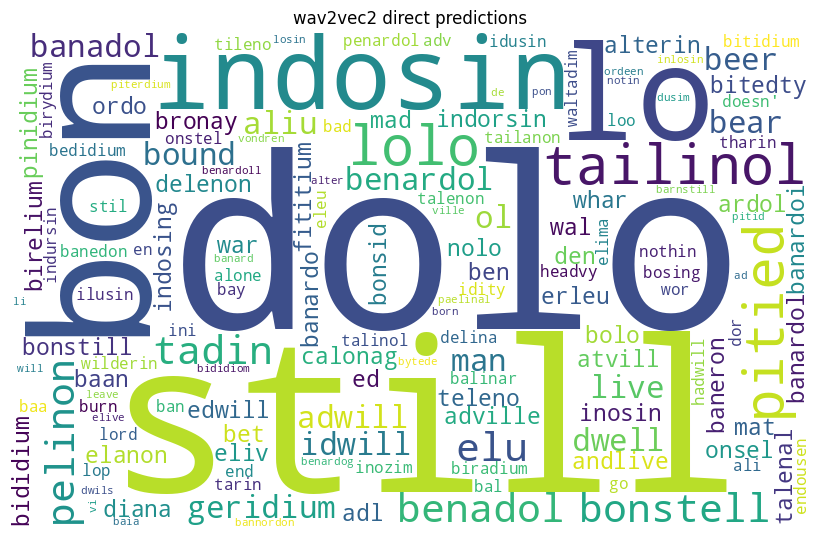

In [65]:
wordcloud = WordCloud(width = 800, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(prediction_str)

plt.figure(figsize = (8, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('wav2vec2 direct predictions')
plt.show()